# Let's build a sequential dataset based on the videos present in the video folder

plan: we are going to go through each image of each video and compute the skeleton keypoints using openpifpaf predictor. From there we compute the angles at the shoulders and elbos and put them in a datafram that will ultimately be pickeld for further use in the NN dataloader.

In [1]:
import os
import openpifpaf
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL
import numpy as np
import seaborn as sns
import cv2

## For video in folder, for image in video

In [2]:
VIDEO_TRAIN_PATH = "video/train/"
DATA_TRAIN_PATH = "data/train/"

VIDEO_TEST_PATH = "video/test/"
DATA_TEST_PATH = "data/test/"

functions to compute the angles based on the coordinates of the arms

In [3]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def compute_angle(depart, arriv1, arriv2):
    """ Returns the angle in radiants between of the arm defined by its shoudler, hip and elbow"""
    v1 = unit_vector(arriv1 - depart)
    v2 = unit_vector(arriv2 - depart)
    return np.arccos(np.clip(np.dot(v1, v2),-1.0,1.0))*360/(2*np.pi)

def compute_angles(predictions, frame_no):
    """ Returns the angle of left and right arm wrt to the torso (return nan if the arm is not seen) """
    
    pos_dict = {
        "nose": 0,
        "left_eye": 1,
        "right_eye": 2,
        "left_ear": 3,
        "right_ear": 4,
        "left_shoudler": 5,
        "right_shoudler": 6,
        "left_elbow": 7,
        "right_elbow": 8,
        "left_wrist": 9,
        "right_wrist": 10,
        "left_hip": 11,
        "right_hip": 12,
        "left_knee": 13,
        "right_knee": 14,
        "left_ankle": 15,
        "right_ankle": 16}
    
    # we suppose only on person on the image (index = 0)
    keypoints = predictions[0].data

    # left shoulder
    left_shoulder = keypoints[pos_dict["left_shoudler"],0:2]
    left_hip = keypoints[pos_dict["left_hip"],0:2]
    left_elbow = keypoints[pos_dict["left_elbow"],0:2]

    # right shoulder
    right_shoulder = keypoints[pos_dict["right_shoudler"],0:2]
    right_hip = keypoints[pos_dict["right_hip"],0:2]
    right_elbow = keypoints[pos_dict["right_elbow"],0:2]

    # left elbow
    left_wrist = keypoints[pos_dict["left_wrist"],0:2]

    # right elbow
    right_wrist = keypoints[pos_dict["right_wrist"],0:2]

    return({"frame": frame_no,
            "left_shoulder": compute_angle(left_shoulder, left_hip, left_elbow), 
            "right_shoulder": compute_angle(right_shoulder, right_hip, right_elbow), 
            "left_elbow": compute_angle(left_elbow, left_shoulder, left_wrist), 
            "right_elbow": compute_angle(right_elbow, right_shoulder, right_wrist)})

predicts the keypoints ands uses them in compute_angles()

In [4]:
def predict_angles(cv2_img, frame_no, predictor=openpifpaf.Predictor(checkpoint='shufflenetv2k16'), resize_x = 0.3, resize_y = 0):
    """ Returns the angles of the left and right arm wrt to the torso and left and right forearm with resepct to the elbow (return nan if the arm is not seen)"""
    resized_img = cv2.resize(cv2_img, None, fx=resize_x, fy=0.3, interpolation=cv2.INTER_AREA)
    recolored_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    pil_img = PIL.Image.fromarray(recolored_img)
    predictions, _, _ = predictor.pil_image(pil_img)
    return compute_angles(predictions, frame_no)

## Create the dataset

In [5]:
def create_dataset(VIDEO_PATH, DATA_PATH):
    """ Creates a dataset of angles for each frame of each video in the VIDEO_PATH folder and save it in the DATA_PATH folder """
    for video in tqdm(os.listdir(VIDEO_PATH)):
        dataFrame = pd.DataFrame(columns=["frame","left_shoulder", "right_shoulder", "left_elbow", "right_elbow"])
        f = os.path.join(VIDEO_PATH, video)
        cap = cv2.VideoCapture(f)
        success, img = cap.read()
        fno = 0
        dataFrame = pd.concat([dataFrame, pd.DataFrame(predict_angles(img, fno), index=[0])])
        while success:
            fno += 1
            sys.stdout.write("\rProcessing frame %i" % fno)
            sys.stdout.flush()
            success, img = cap.read()
            if not success:
                break
            dataFrame = pd.concat([dataFrame, pd.DataFrame(predict_angles(img, fno), index=[0])])
        dataFrame.to_pickle(os.path.join(DATA_PATH, video[:-4]+".pkl"))

In [6]:
create_dataset(VIDEO_TRAIN_PATH, DATA_TRAIN_PATH)
create_dataset(VIDEO_TEST_PATH, DATA_TEST_PATH)

  0%|          | 0/10 [00:00<?, ?it/s]

Processing frame 36

  0%|          | 0/10 [00:19<?, ?it/s]


KeyboardInterrupt: 

## Read pickle files and plot sutff to find patterns

In [7]:
print(DATA_TRAIN_PATH)

data/train/


In [8]:
roll_droite_gui = pd.read_pickle(DATA_TRAIN_PATH+"roll-droite-gui.pkl")
roll_droite_gui.head()

,frame,left_shoulder,right_shoulder,left_elbow,right_elbow
0,0,20.345068,52.635147,159.309755,131.332149
0,1,19.886782,53.183827,160.044700,135.191289
0,2,20.353808,54.401734,159.606777,146.934399
0,3,20.187477,55.859881,160.775369,155.751615
0,4,20.074795,56.871123,163.473065,168.102077


In [12]:
idle_gui = pd.read_pickle(DATA_TRAIN_PATH+"idle-gui.pkl")
idle_gui

,frame,left_shoulder,right_shoulder,left_elbow,right_elbow
0,0,18.271933,22.966771,165.236316,165.491436
0,1,18.221902,22.142878,164.719307,166.346748
0,2,17.796397,22.183759,165.024057,166.521153
0,3,18.170206,21.771864,164.150443,166.725198
0,4,18.047809,21.856094,163.844965,166.071028
...,...,...,...,...,...
0,959,10.185648,20.670624,73.920039,73.779138
0,960,9.433944,21.010570,74.444621,72.912103
0,961,9.700548,21.645374,73.072013,71.907450
0,962,9.567169,21.391945,74.699321,73.009257


In [56]:
dfm = roll_droite_gui.melt(id_vars=["frame"], var_name="keypoint", value_name="angle")

we go only from 0 to 180 beacuse cos is an even functiuon (cos(x) == cos(-x)) and arcos will always give the positive angle.

[Text(0.5, 1.0, 'Angles of roll with right arm')]

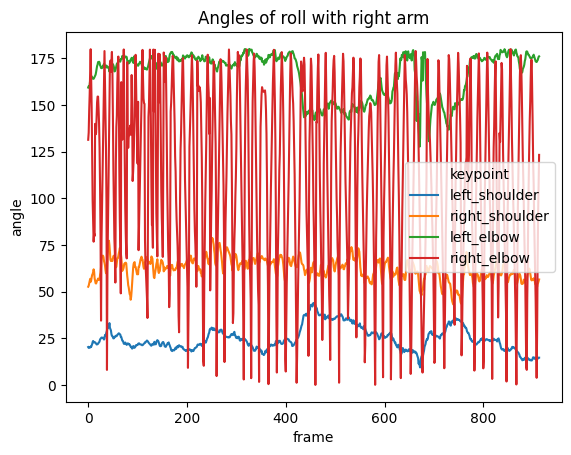

In [57]:
sns.lineplot(data=dfm, x="frame", y="angle", hue="keypoint").set(title="Angles of roll with right arm")

[Text(0.5, 1.0, 'Angles of roll with left arm')]

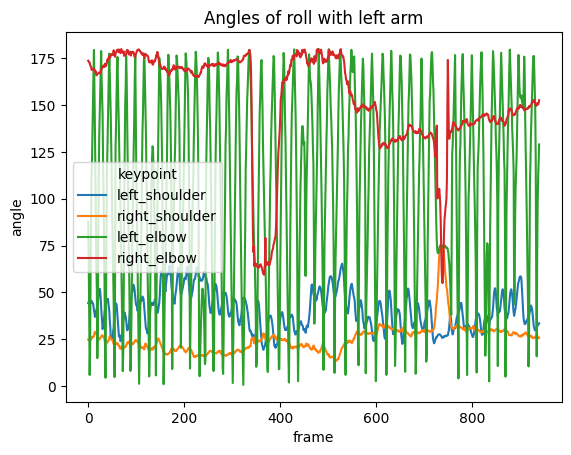

In [59]:
roll_gauche_gui = pd.read_pickle(DATA_PATH+"roll-gauche-gui.pkl")
dfm = roll_gauche_gui.melt(id_vars=["frame"], var_name="keypoint", value_name="angle")
sns.lineplot(data=dfm, x="frame", y="angle", hue="keypoint").set(title="Angles of roll with left arm")

[Text(0.5, 1.0, 'Angles of salute with right arm')]

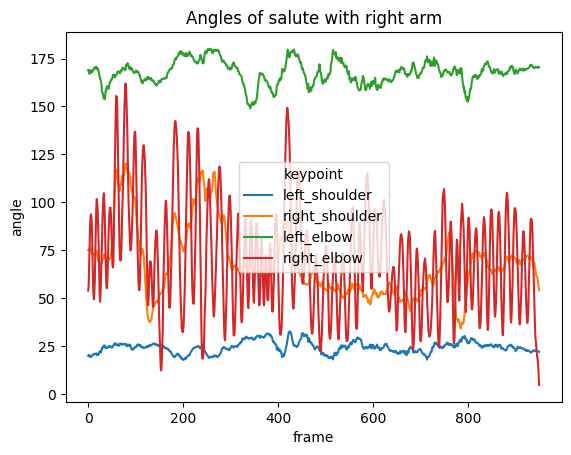

In [60]:
salut_droite_gui = pd.read_pickle(DATA_PATH+"salut-droite-gui.pkl")
dfm = salut_droite_gui.melt(id_vars=["frame"], var_name="keypoint", value_name="angle")
sns.lineplot(data=dfm, x="frame", y="angle", hue="keypoint").set(title="Angles of salute with right arm")

[Text(0.5, 1.0, 'Angles of salute with left arm')]

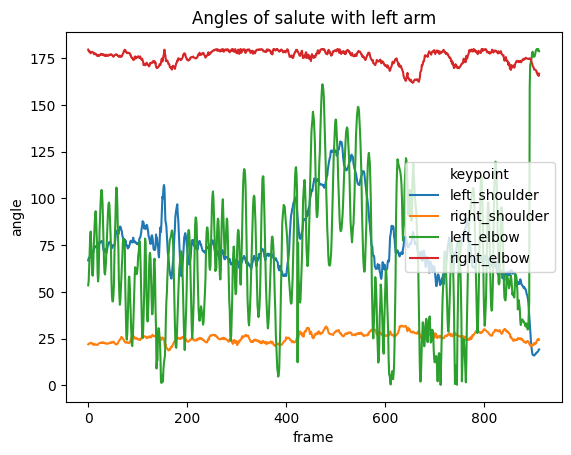

In [61]:
salut_gauche_gui = pd.read_pickle(DATA_PATH+"salut-gauche-gui.pkl")
dfm = salut_gauche_gui.melt(id_vars=["frame"], var_name="keypoint", value_name="angle")
sns.lineplot(data=dfm, x="frame", y="angle", hue="keypoint").set(title="Angles of salute with left arm")